# EP03 da disciplina de Visão e Processamento de Imagens
## (MAC5768/MAC0417 -- 2020)

|Nomes:                        | N° USP:|
|------------------------------|--------|
|Alana Ilen Cermak             | 10737967|
|Francisco Edvar da Cunha Filho | 10656115|
|Marcos Markevich              | 11373435|

Link para pasta no drive: https://drive.google.com/drive/folders/1Qc0gAhNhfqMOcWeW5aDH7WcEgftJjq12?usp=sharing

Link para o github do grupo: https://github.com/franciscoedvar/EPs_Visao_Computacional

<p>Este é o primeiro notebook do EP03 onde, usando redes do algoritmo U-NET, consegue-se criar segmentações automáticas das classes que temos como dados. Os modelos foram treinados e estão nos arquivos .h5 que devem acompanhar o notebook. Os resultados podem ser considerados satisfatórios, dando melhores resultados em classes em que treinamos mais, logicamente, mas em algumas que tiveram a mesma exposição a treino, como Folha e Chave, o algoritmo se mostrou mais eficiente em um do que no outro. Folha, teve um valor final de treinamento de 0.00424 de loss e um valor de MeanIoU de 0.5222, já a chave, os mesmos dados foram de 0.00698 e 0.4866. O Algoritmo foi desenvolvido a partir deste artigo:
https://arxiv.org/pdf/1505.04597.pdf</p>

# Imports

In [11]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input, Flatten
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import tensorflow as tf 
import cv2
import random

In [12]:
# Definição de hiperparametros. Preencha principalmente as pastas com os links locais

#Dimensões imagens
img_a = 1280
img_l = 720

#Pasta das imagens gerados pelo pipeline 2.1 e 2.2
pastanormal = './dados/fotos_1280_720_augmented/'

#Pasta da segmentação manual (groundtruth input), fornecido no drive do grupo
pastagroundtruth = './dados/fotos_1280_720_groundtruth/'

#Pasta para salvar segmentação automática (output deste notebook), output fornecido no drive do grupo
pastaautosegmentada = './dados/fotos_1280_720_autosegmentada'

#Pasta para salvar modelos
pastamodelo = './dados/'  

#Classes para realizar treinamento e segmentação automática
classes = ['1. Caneca','2. Garfo','3. Isqueiro','4. Livro','5. Mouse','6. Tenis','7. Bola','8. Caneta','9. Chave','10. Folha']

# Corpo do modelo U-Net.

In [13]:
entra = Input((1280, 720, 1))
s = Lambda(lambda x: x / 255) (entra)

c1 = Conv2D(4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(4, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

sai = Conv2D(1, (1, 1), activation='sigmoid') (c9)

# Funções 

In [5]:
def mnist_like_plot(img_per_row = 10, sample_size= 100, img_root = './',  **options):
    '''Plot formato mnist'''
    all_imgs = imgs_mnist(sample_size, img_root)
    imgs = all_imgs 
    num_img_per_row = min(len(imgs), img_per_row)
    num_rows = (len(imgs) - 1) // num_img_per_row + 1
    all_rows = []
    for i in range(num_rows):
        row = all_imgs[ i * num_img_per_row : (i + 1) * num_img_per_row]
        all_rows.append(np.concatenate(row, axis=1))
    img_grid = np.concatenate(all_rows, axis = 0)
    plt.figure(figsize=(15,25))
    plt.imshow(img_grid, **options)
    plt.axis('off')
    
    del img_grid
    return 

def imgs_mnist(sample_size,root_dir = './'):
    '''Leitura de imagens para plot mnist'''
    all_imgs = read_imgs(root_dir) 
    all_imread = []
    all_imgs = random.sample(all_imgs, sample_size)
    for i in range(len(all_imgs)):
        all_imread.append(imread(all_imgs[i]))

    return all_imread


os.chdir('./')

def read_imgs(pasta):
    '''Retorna uma lista com o nome dos arquivos dentro da pasta informada'''
    all_imgs = [pasta + '/' + filename for filename in os.listdir(pasta)]
    return all_imgs

def getDatTrainData(classe = '2. Garfo'):
    '''Retorna dados de treinamento
    Expandida para usar a mesma groundtruth para imagens iguais,
    estas que só tem o tratamento de cor diferente.
    
    Informar a classe pelo vetor de classes.'''
    imgs = read_imgs(pastagroundtruth + classe)
    no_img = len(imgs)
    X_train = []
    Y_train =[]
        
    for n, id_ in tqdm(enumerate(imgs), total=no_img):
        Y_train.append(id_)
        X_train.append(pastanormal + classe + '/' + id_[len(pastagroundtruth)+len(classe)+5:-3] + 'jpg')
        num = id_[-10:]
        files = [os.path.join(root, name)
                 for root, dirs, files in os.walk(pastanormal + classe)
                 for name in files
                 if name.endswith((num)) and not name.startswith(('mean'))]
        for file in files:
            if file not in X_train:
                Y_train.append(id_)
                X_train.append(file)
                
    X = np.zeros((len(X_train), img_a, img_l, 1), dtype=np.uint8)
    Y = np.zeros((len(X_train), img_a, img_l), dtype=np.bool)
    
    for i in range(len(X_train)):
        Y[i] = imread(Y_train[i], 0).reshape((1280,720)) != 0
        X[i] = imread(X_train[i]).reshape((1280,720, 1))
        
    return X, Y

def getDatTestData(classe = '2. Garfo'):
    '''Retorna dados para previsão.
    Retorna todas as imagens que não tem groundtruth feito.
    Serão usadas para predição do modelo e as previsões serão salvas
    na pastaautosegmentada'''
    
    imgs = read_imgs(pastagroundtruth + classe)
    no_img = len(imgs)
    X_train = []
        
    for n, id_ in tqdm(enumerate(imgs), total=no_img):
        X_train.append(pastanormal + classe + '/' + id_[len(pastagroundtruth)+len(classe)+5:])
        numid = id_[-10:]
        files = [os.path.join(root, name)
                 for root, dirs, files in os.walk(pastanormal + classe)
                 for name in files
                 if name.endswith((numid)) and not name.startswith(('mean'))]
        for file in files:
            if file not in X_train:
                X_train.append(file)
                
    imgsR = read_imgs(pastanormal + classe)
    imgsR = [img for img in imgsR if img not in X_train]
    no_img = len(imgsR)
    
    test = []
    
    for n, id_ in tqdm(enumerate(imgsR), total=no_img):
        test.append(imread(id_).reshape((1280,720, 1)))
    
    test = np.array(test)
    return test, imgsR

In [15]:
def AutoSegmentar(classe = '2. Garfo', load = True, train = False, summary = True, plot= False, predict = False):
    '''Função principal. 
    Opções:
    classe: 'str', classe da lista classes para o modelo especifico.
    load: 'bool', True or False para carregar um modelo apartir de um arquivo .h5
    train: 'bool', True of False para treinar o modelo, #CUIDADO PESADO#
    summary: 'bool', True of False para mostrar o sumário com informações do modelo,
    plot: 'bool', True or False para plotar as imagens da pasta autosegmentada
    predict:'bool', True or False para o modelo fazer a predição dos dados de teste. Salva
        as imagens na pasta autosegmentada'''
    
    
    if load:
        print("Carregando modelo a partir de arquivo.....")
        try:
            modelo = load_model(pastamodelo + classe[3:] + '.h5',
            custom_objects=None,
            compile=False)
        except:
            print(pastamodelo + classe[3:] + '.h5')
            print("Nenhum arquivo encontrado...")
            modelo = Model(inputs=entra, outputs=sai)
    else:
        modelo = Model(inputs=entra, outputs=sai)
    
    
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    X_train, Y_train = getDatTrainData(classe)
    
    if train:
        earlystopper = EarlyStopping(patience=5, verbose=1, monitor = 'loss')
        checkpointer = ModelCheckpoint(pastamodelo + classe[3:] + '.h5', verbose=1, save_best_only=True, monitor = 'loss')
        with tf.device("/device:CPU:0"):
            results = modelo.fit(X_train, Y_train, epochs=50, steps_per_epoch=100, callbacks=[earlystopper, checkpointer], validation_split=0.1)
    
    if summary:
        print('Modelo de '+ classe[3:])
        print('Encontra-se salvo em '+ pastamodelo + classe[3:] + '.h5')
        modelo.summary()
        with tf.device("/device:CPU:0"):
            results = modelo.evaluate(X_train, Y_train, batch_size=10, verbose = 0)
        print('Loss = %s, Acurácia= %s, MeanIoU= %s'%(results[0], results[1], results[2]))
    
    test, testids =  getDatTestData(classe)
    
    if predict:
        with tf.device("/device:CPU:0"):
            testado = modelo.predict(test, verbose=1)

        for i in range(len(test)):
            img = (testado[i] > 0.5).astype(int) * 255
            img = img.reshape((img_a, img_l))
            image = np.zeros((img_a, img_l, 3), dtype=np.uint8)
            image[:,:,0] = img
            image[:,:,1] = img
            image[:,:,2] = img
            matplotlib.image.imsave(pastaautosegmentada + classe + '/' + 'auto_' + testids[i][len(pastanormal) + len(classe) + 1:], image)

        print("Feito :). Imagens salvas em:" + pastaautosegmentada + classe + '/')
    
    if plot == True:
        mnist_like_plot(img_per_row = 3, sample_size= 9, img_root = pastaautosegmentada + '/' + classe + '/')
    

  0%|          | 0/54 [00:00<?, ?it/s]

Carregando modelo a partir de arquivo.....


100%|██████████| 54/54 [00:00<00:00, 3285.12it/s]


Epoch 1/50
100/100 [==============================] - 111s 1s/step - loss: 0.0075 - accuracy: 0.9969 - mean_io_u_19: 0.4935 - val_loss: 0.0084 - val_accuracy: 0.9969 - val_mean_io_u_19: 0.4935

Epoch 00001: loss improved from inf to 0.00815, saving model to /home/marquos/Imagens/fotosep/Garfo.h5
Epoch 2/50
100/100 [==============================] - 110s 1s/step - loss: 0.0069 - accuracy: 0.9971 - mean_io_u_19: 0.4930 - val_loss: 0.0089 - val_accuracy: 0.9968 - val_mean_io_u_19: 0.4935

Epoch 00002: loss improved from 0.00815 to 0.00652, saving model to /home/marquos/Imagens/fotosep/Garfo.h5
Epoch 3/50
100/100 [==============================] - 110s 1s/step - loss: 0.0060 - accuracy: 0.9974 - mean_io_u_19: 0.4935 - val_loss: 0.0084 - val_accuracy: 0.9967 - val_mean_io_u_19: 0.4935

Epoch 00003: loss improved from 0.00652 to 0.00632, saving model to /home/marquos/Imagens/fotosep/Garfo.h5
Epoch 4/50
100/100 [==============================] - 110s 1s/step - loss: 0.0062 - accuracy: 0.9974 

  8%|▊         | 30/360 [00:00<00:01, 298.39it/s]

Loss = 0.009446507319808006, Acurácia= 0.9972591996192932, MeanIoU= 0.49332600831985474


100%|██████████| 360/360 [00:01<00:00, 327.62it/s]


12/12 [==============================] - 76s 6s/step
Feito :). Imagens salvas em:/home/marquos/Imagens/fotosep/fotos_1280_720_autosegmentada/2. Garfo/


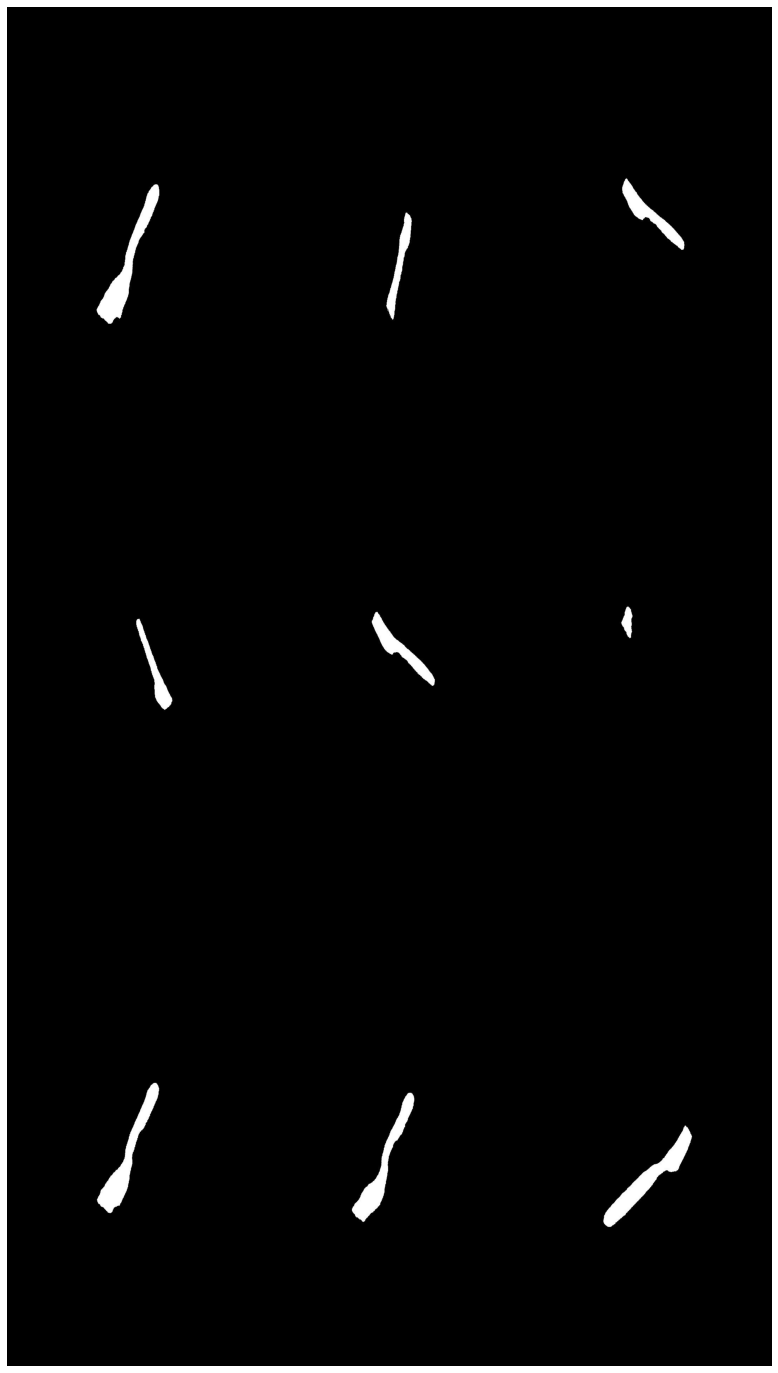

In [17]:
'''Para melhor visualização, melhor rodar por classes.'''
AutoSegmentar(classe = classes[1], load = True, train= True, summary = True, plot = True, predict = True)